In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import xgboost as xgb
import catboost as cat
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
def upsample(dataframe):
    df_0 = dataframe[dataframe.age_group==0]
    df_1 = dataframe[dataframe.age_group==1]
    df_2 = dataframe[dataframe.age_group==2]
    df_3 = dataframe[dataframe.age_group==3]

    max_count = max([len(df_0), len(df_1), len(df_2), len(df_3)])

    df_0 = resample(df_0, replace=True, n_samples=max_count, random_state=42)
    df_1 = resample(df_1, replace=True, n_samples=max_count, random_state=42)
    df_2 = resample(df_2, replace=True, n_samples=max_count, random_state=42)
    df_3 = resample(df_3, replace=True, n_samples=max_count, random_state=42)

    return pd.concat([df_0, df_1, df_2, df_3])

In [65]:
def ordered_features(feature_importances, features):
    ordered = []
    importances = []
    
    while(len(ordered) < len(features)):
        max_fea = 0
        max_pos = 0
        for i in range(len(features)):
            if feature_importances[i] > max_fea and features[i] not in ordered:
                max_fea = feature_importances[i]
                max_pos = i
        ordered.append(features[max_pos])
        importances.append(max_fea)
    
    ordered.reverse()
    importances.reverse()
    
    fig = plt.figure()
    f, ax = plt.subplots(figsize=(10,10))
    ax.barh(ordered, importances)
    ax.set_xlabel('Importance')
    ax.set_title('Feature Importances')
    plt.show()

In [4]:
train_data = pd.read_csv('train_w_logits_and_embeddings.csv')
test_data = pd.read_csv('test_w_logits_and_embeddings.csv')

rs = 42

In [5]:
drop_columns = ['Unnamed: 0', 'handle', 'tweets_text', 'hashtags']

train_col = train_data.columns
for col in train_col:
    if 'embed' in col:
        drop_columns.append(col)

In [6]:
train_data = train_data.drop(drop_columns, axis=1)
test_data = test_data.drop(drop_columns, axis=1)

train_data_up = upsample(train_data)

In [7]:
tests = 1000
max_acc = 0
best_rs = 0
for i in range(tests):
    rfc = RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_split=2, min_samples_leaf=5, random_state=i)
    rfc.fit(train_data.drop('age_group', axis=1).fillna(0), train_data['age_group'])
    
    label_pred = rfc.predict(test_data.drop('age_group', axis=1).fillna(0))
    acc = accuracy_score(test_data['age_group'], label_pred, normalize='true')
    
    if acc > max_acc:
        max_acc = acc
        best_rs = i
        print(best_rs)
        print(acc)

0
0.5741176470588235
12
0.5764705882352941
47
0.5811764705882353
339
0.5835294117647059


In [8]:
rfc = RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_split=2, min_samples_leaf=5, random_state=best_rs)
rfc.fit(train_data.drop('age_group', axis=1).fillna(0), train_data['age_group'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=339,
                       verbose=0, warm_start=False)

In [9]:
label_pred = rfc.predict(test_data.drop('age_group', axis=1).fillna(0))
accuracy_score(test_data['age_group'], label_pred, normalize='true')

0.5835294117647059

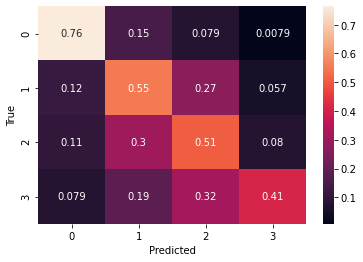

In [10]:
cm = confusion_matrix(test_data['age_group'], label_pred, normalize='true')
df_cm = pd.DataFrame(cm, range(4), range(4))
sn.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

<Figure size 432x288 with 0 Axes>

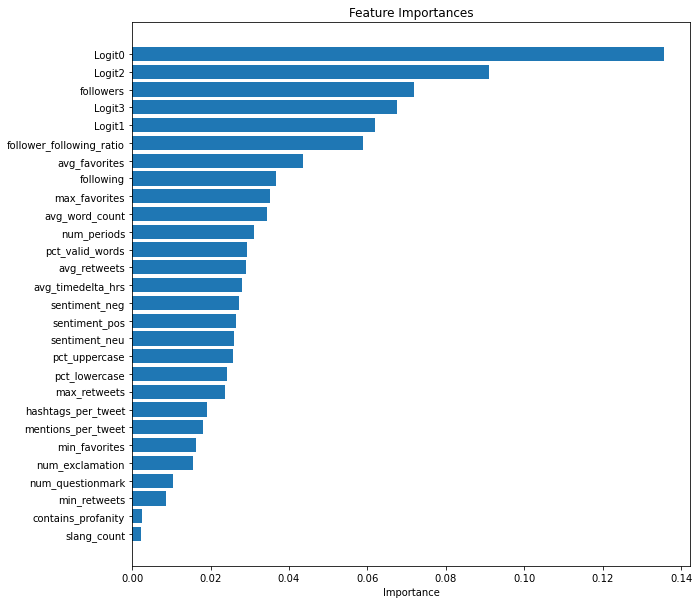

In [66]:
features = list(test_data.columns)
features.remove('age_group')
ordered_features(rfc.feature_importances_, features)

In [12]:
param_test = {
    'n_estimators': [100*(i+5) for i in range(5)],
    'max_depth': [i+10 for i in range(5)],
    'min_samples_split': [i+1 for i in range(5)],
    'min_samples_leaf': [i+1 for i in range(5)]
}

gsearch = GridSearchCV(estimator = RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_split=2, min_samples_leaf=5, random_state=rs),
                        param_grid = param_test, scoring='accuracy', n_jobs=4, iid=False, cv=5, verbose=True)

gsearch.fit(train_data_up.drop('age_group', axis=1).fillna(0), train_data_up['age_group'])
gsearch.best_params_, gsearch.best_score_

Fitting 5 folds for each of 625 candidates, totalling 3125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  8.5min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 12.3min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 16.9min
[Parallel(n_jobs=4)]: Done 3125 out of 3125 | elapsed: 21.9min finished
c:\users\bab72\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'max_depth': 14,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 800},
 0.8468329055127735)

In [13]:
tests = 1000
max_acc = 0
best_rs = 0
for i in range(tests):
    rfc_up = RandomForestClassifier(n_estimators=gsearch.best_params_['n_estimators'], max_depth=gsearch.best_params_['max_depth'],
                                    min_samples_split=gsearch.best_params_['min_samples_split'], min_samples_leaf=gsearch.best_params_['min_samples_leaf'], random_state=i)
    rfc_up.fit(train_data_up.drop('age_group', axis=1).fillna(0), train_data_up['age_group'])
    
    label_pred = rfc_up.predict(test_data.drop('age_group', axis=1).fillna(0))
    acc = accuracy_score(test_data['age_group'], label_pred, normalize='true')
    
    if acc > max_acc:
        max_acc = acc
        best_rs = i
        print(best_rs)
        print(acc)

0
0.5176470588235295
1
0.52
2
0.5223529411764706
5
0.5247058823529411
6
0.5270588235294118
7
0.5341176470588235
15
0.5411764705882353
259
0.5435294117647059


In [14]:
rfc_up = RandomForestClassifier(n_estimators=gsearch.best_params_['n_estimators'], max_depth=gsearch.best_params_['max_depth'],
                                min_samples_split=gsearch.best_params_['min_samples_split'], min_samples_leaf=gsearch.best_params_['min_samples_leaf'], random_state=best_rs)
rfc_up.fit(train_data_up.drop('age_group', axis=1).fillna(0), train_data_up['age_group'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=259,
                       verbose=0, warm_start=False)

In [15]:
label_pred = rfc_up.predict(test_data.drop('age_group', axis=1).fillna(0))
accuracy_score(test_data['age_group'], label_pred, normalize='true')

0.5435294117647059

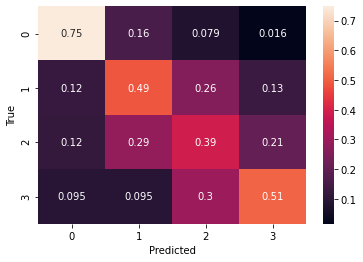

In [16]:
cm = confusion_matrix(test_data['age_group'], label_pred, normalize='true')
df_cm = pd.DataFrame(cm, range(4), range(4))
sn.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

<Figure size 432x288 with 0 Axes>

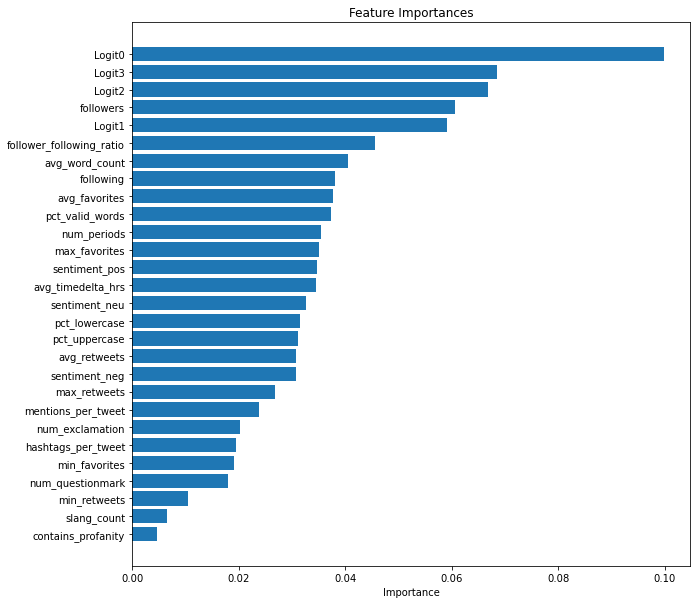

In [67]:
features = list(test_data.columns)
features.remove('age_group')
ordered_features(rfc_up.feature_importances_, features)

### Stacking the Two Models

In [70]:
meta_train = rfc.predict_proba(train_data.drop('age_group', axis=1).fillna(0))
meta_train_up = rfc_up.predict_proba(train_data.drop('age_group', axis=1).fillna(0))

total_meta_train = []

for i in range(len(meta_train)):
    total_meta_train.append([0, 0, 0, 0, 0, 0, 0, 0])
    
    total_meta_train[i][0] = meta_train[i][0]
    total_meta_train[i][1] = meta_train[i][1]
    total_meta_train[i][2] = meta_train[i][2]
    total_meta_train[i][3] = meta_train[i][3]
    total_meta_train[i][4] = meta_train_up[i][0]
    total_meta_train[i][5] = meta_train_up[i][1]
    total_meta_train[i][6] = meta_train_up[i][2]
    total_meta_train[i][7] = meta_train_up[i][3]
    
total_meta_train_temp = pd.DataFrame(total_meta_train)

In [71]:
total_meta_train = train_data.copy()
total_meta_train['rfc_0'] = total_meta_train_temp[0]
total_meta_train['rfc_1'] = total_meta_train_temp[1]
total_meta_train['rfc_2'] = total_meta_train_temp[2]
total_meta_train['rfc_3'] = total_meta_train_temp[3]
total_meta_train['rfc_up_0'] = total_meta_train_temp[4]
total_meta_train['rfc_up_1'] = total_meta_train_temp[5]
total_meta_train['rfc_up_2'] = total_meta_train_temp[6]
total_meta_train['rfc_up_3'] = total_meta_train_temp[7]

In [72]:
meta_test = rfc.predict_proba(test_data.drop('age_group', axis=1).fillna(0))
meta_test_up = rfc_up.predict_proba(test_data.drop('age_group', axis=1).fillna(0))

total_meta_test = []

for i in range(len(meta_test)):
    total_meta_test.append([0, 0, 0, 0, 0, 0, 0, 0])
    
    total_meta_test[i][0] = meta_test[i][0]
    total_meta_test[i][1] = meta_test[i][1]
    total_meta_test[i][2] = meta_test[i][2]
    total_meta_test[i][3] = meta_test[i][3]
    total_meta_test[i][4] = meta_test_up[i][0]
    total_meta_test[i][5] = meta_test_up[i][1]
    total_meta_test[i][6] = meta_test_up[i][2]
    total_meta_test[i][7] = meta_test_up[i][3]
    
total_meta_test_temp = pd.DataFrame(total_meta_test)

total_meta_test = test_data.copy()
total_meta_test['rfc_0'] = total_meta_test_temp[0]
total_meta_test['rfc_1'] = total_meta_test_temp[1]
total_meta_test['rfc_2'] = total_meta_test_temp[2]
total_meta_test['rfc_3'] = total_meta_test_temp[3]
total_meta_test['rfc_up_0'] = total_meta_test_temp[4]
total_meta_test['rfc_up_1'] = total_meta_test_temp[5]
total_meta_test['rfc_up_2'] = total_meta_test_temp[6]
total_meta_test['rfc_up_3'] = total_meta_test_temp[7]

In [21]:
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_split=2, min_samples_leaf=5, random_state=rs),
                        param_grid = param_test, scoring='accuracy', n_jobs=4, iid=False, cv=5, verbose=True)

gsearch2.fit(total_meta_train.drop('age_group', axis=1).fillna(0), train_data['age_group'])
gsearch2.best_params_, gsearch2.best_score_

Fitting 5 folds for each of 625 candidates, totalling 3125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  7.7min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 11.1min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 15.2min
[Parallel(n_jobs=4)]: Done 3125 out of 3125 | elapsed: 19.6min finished
c:\users\bab72\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'max_depth': 13,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 600},
 0.9717508242234947)

In [22]:
tests = 1000
max_acc = 0
best_rs = 0
for i in range(tests):    
    meta_model = RandomForestClassifier(n_estimators=gsearch2.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
                                    min_samples_split=gsearch2.best_params_['min_samples_split'], min_samples_leaf=gsearch2.best_params_['min_samples_leaf'], random_state=i)
    meta_model.fit(total_meta_train.drop('age_group', axis=1).fillna(0), train_data['age_group'])
    
    label_pred = meta_model.predict(total_meta_test.drop('age_group', axis=1).fillna(0))
    acc = accuracy_score(total_meta_test['age_group'], label_pred, normalize='true')
    
    if acc > max_acc:
        max_acc = acc
        best_rs = i
        print(best_rs)
        print(acc)

0
0.5670588235294117
2
0.571764705882353
50
0.5741176470588235
157
0.5764705882352941
534
0.5788235294117647


In [23]:
meta_model = RandomForestClassifier(n_estimators=gsearch2.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
                                    min_samples_split=gsearch2.best_params_['min_samples_split'], min_samples_leaf=gsearch2.best_params_['min_samples_leaf'], random_state=best_rs)
meta_model.fit(total_meta_train.drop('age_group', axis=1).fillna(0), train_data['age_group'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=534,
                       verbose=0, warm_start=False)

In [24]:
total_label = meta_model.predict(total_meta_test.drop('age_group', axis=1).fillna(0))

In [25]:
accuracy_score(test_data['age_group'], total_label, normalize='true')

0.5788235294117647

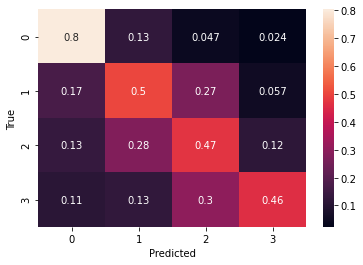

In [26]:
cm = confusion_matrix(test_data['age_group'], total_label, normalize='true')
df_cm = pd.DataFrame(cm, range(4), range(4))
sn.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

<Figure size 432x288 with 0 Axes>

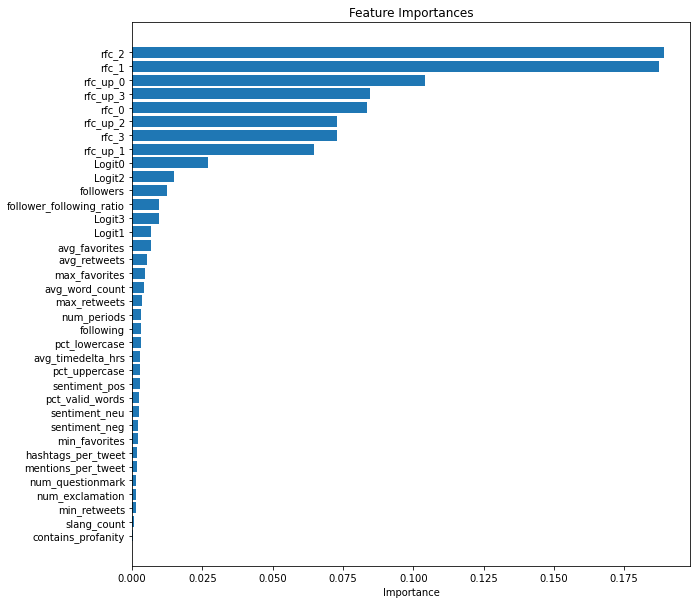

In [73]:
features = list(total_meta_test.columns)
features.remove('age_group')
ordered_features(meta_model.feature_importances_, features)